## Avatar : The Last Airbender - EDA

This notebook analyses all transcipts downloaded via the scrape_episode_urls.py script. 

Note on the vocabulary used: A "Book" is equivalent to a season. An "utterance" or "line" is one or more sentences spoken by the same character; one line in the CSV files will correspond to one utterance.

In [40]:
#all necessary imports
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
import glob
import re

In [2]:
files = glob.glob('raw_data/*.csv')

In [3]:
def get_book_number(item):
    m = re.search("_(\d)_(\d*).*\.csv",item)
    return int(m.string[m.start(1):m.end(1)])

In [4]:
def get_episode_number(item):
    m = re.search("_(\d)_(\d*).*\.csv",item)
    return int(m.string[m.start(2):m.end(2)])

In [5]:
files.sort(key=get_episode_number)
files.sort(key=get_book_number)

In [6]:
df_list = []
for f in files:
    df = pd.read_csv(f, sep=",", header=None, names=["Character", "Utterance"])
    episode_number = get_episode_number(f)
    book_number = get_book_number(f)
    df["Book"] = book_number
    df["Episode"] = episode_number
    df_list.append(df)
    
transcripts = pd.concat(df_list, axis=0, ignore_index=True)

### Exploring the data

There are 9912 total lines and 61 episodes split over 3 Books (seasons). 

In [7]:
transcripts.sample(3, random_state=20)['Utterance'].to_list()

["Great! We can travel through the Serpent's Pass together.",
 "I'm begging you, Prince Zuko! It's time for you to look inward and begin asking yourself the big questions. Who are you, and what do you want?",
 'About that!']

In [8]:
transcripts[['Book','Episode']].drop_duplicates().shape[0]

61

In [9]:
transcripts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Character  9912 non-null   object
 1   Utterance  9912 non-null   object
 2   Book       9912 non-null   int64 
 3   Episode    9912 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 309.9+ KB


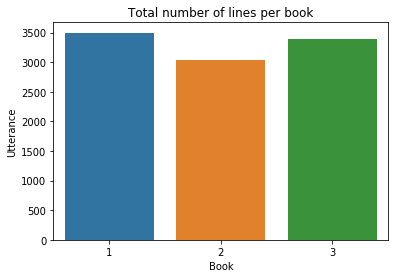

In [10]:
ax = sns.barplot(x="Book", y="Utterance", data=transcripts.groupby('Book').count().reset_index())
ax.set_title("Total number of lines per book")
plt.show()

In [11]:
total_lines_per_person = transcripts.groupby("Character").count()

In [12]:
top_15_characters_lines = total_lines_per_person.sort_values(by="Utterance", ascending=False).head(15).reset_index()

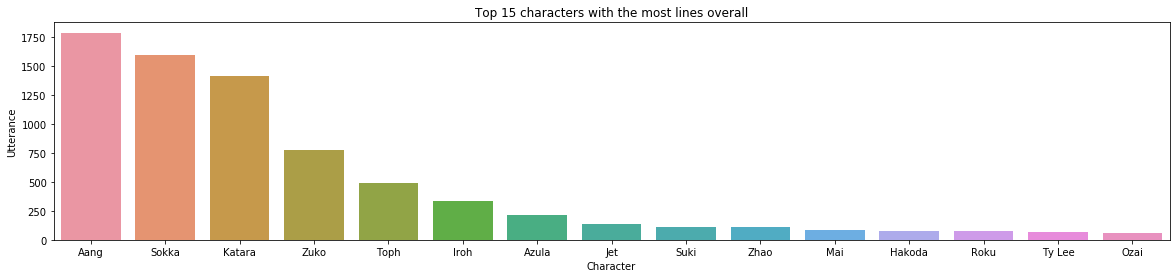

In [13]:
plt.figure(figsize=(20,4))
ax = sns.barplot(x="Character", y="Utterance", data=top_15_characters_lines)
ax.set_title("Top 15 characters with the most lines overall")
plt.show()

Unsurprisingly, it's the main trio (Aang, Sokka & Katara) that speak the most.

In [14]:
top_15_characters = top_15_characters_lines['Character'].to_list()
total_lines_per_book = transcripts.groupby(["Character", "Book"]).count().loc[top_15_characters].reindex(top_15_characters, level=0)

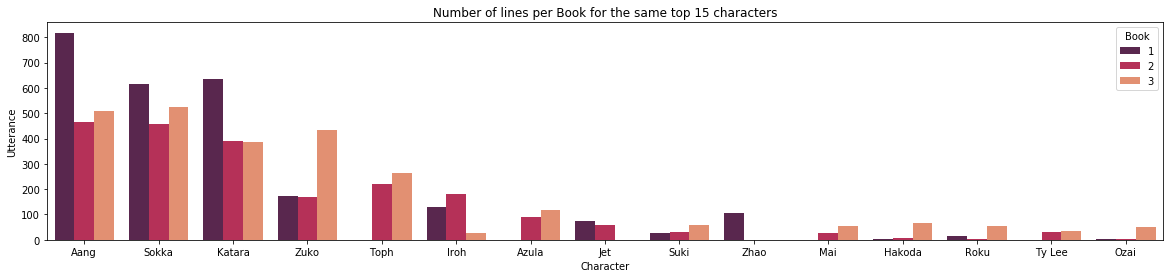

In [15]:
plt.figure(figsize=(20,4))
ax = sns.barplot(x="Character", y="Utterance", hue="Book", data=total_lines_per_book.reset_index(), palette="rocket")
ax.set_title("Number of lines per Book for the same top 15 characters")
plt.show()

### Using spacy's medium-sized English language model

In [37]:
nlp = spacy.load("en_core_web_md")

In [48]:
#Please uncomment the following two lines if loading the English language model failed:
#%%bash
#python -m spacy download en_core_web_sm

In [68]:
def count_verbs_adj_noun(texts):
    verb_count = defaultdict(int)
    adj_count = defaultdict(int)
    noun_count = defaultdict(int)

    for line in texts:
        doc = nlp(line)
        for token in doc:
            if token.is_stop:
                continue
            if token.pos_ == 'VERB':
                verb_count[token.lemma_] += 1
            elif token.pos_ == 'ADJ':
                adj_count[token.lemma_] += 1
            elif token.pos_ == 'NOUN':
                noun_count[token.lemma_] += 1
    return verb_count, adj_count, noun_count

In [69]:
def top_10_tokens(tokens_dict):
    return sorted(tokens_dict.items(), key=lambda kv: kv[1], reverse=True)[:10]

In [70]:
verb_count, adj_count, noun_count = count_verbs_adj_noun(transcripts['Utterance'].to_list())

In [71]:
top_10_verbs = top_10_tokens(verb_count)
top_10_adjectives = top_10_tokens(adj_count)
top_10_nouns = top_10_tokens(noun_count)

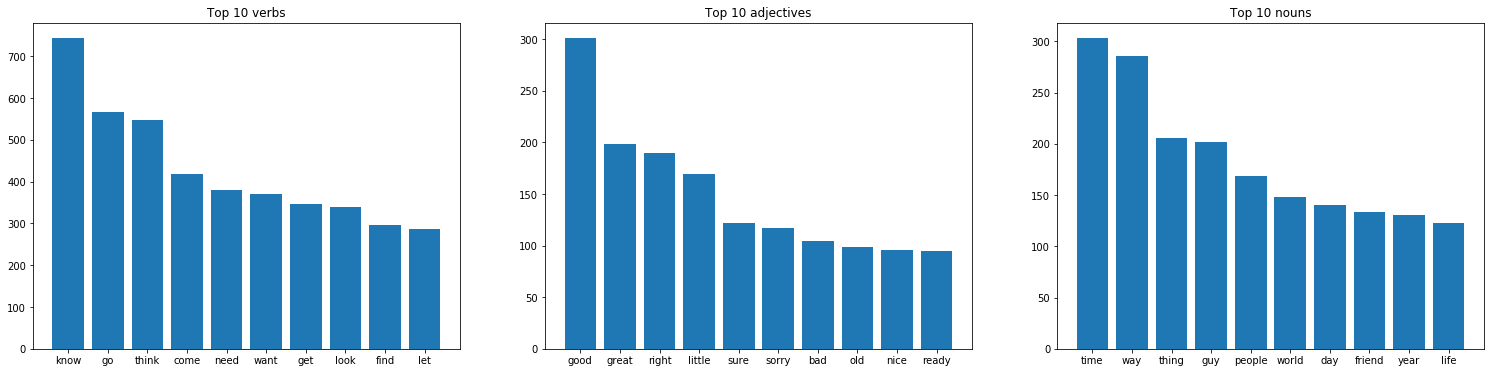

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(26, 6))
axes[0].bar([x[0] for x in top_10_verbs], [x[1] for x in top_10_verbs])
axes[0].set_title("Top 10 verbs")
axes[1].bar([x[0] for x in top_10_adjectives], [x[1] for x in top_10_adjectives])
axes[1].set_title("Top 10 adjectives")
axes[2].bar([x[0] for x in top_10_nouns], [x[1] for x in top_10_nouns])
axes[2].set_title("Top 10 nouns")
plt.show()

In [73]:
zuko_lines = transcripts[transcripts["Character"] == "Zuko"]["Utterance"].to_list()
zuko_verb_count, zuko_adj_count, zuko_noun_count = count_verbs_adj_noun(zuko_lines)
zuko_top_10_verbs = top_10_tokens(zuko_verb_count)
zuko_top_10_adjectives = top_10_tokens(zuko_adj_count)
zuko_top_10_nouns = top_10_tokens(zuko_noun_count)

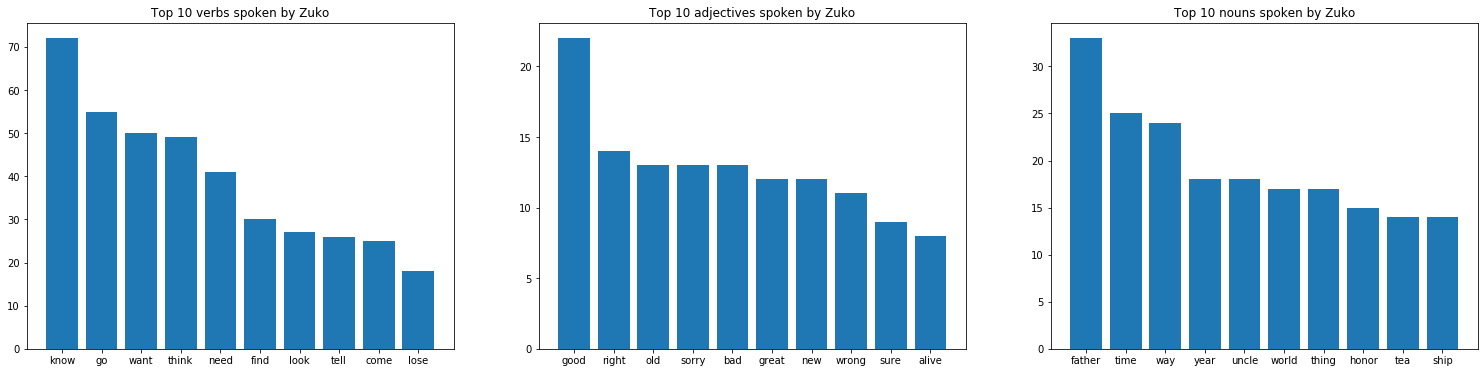

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(26, 6))
axes[0].bar([x[0] for x in zuko_top_10_verbs], [x[1] for x in zuko_top_10_verbs])
axes[0].set_title("Top 10 verbs spoken by Zuko")
axes[1].bar([x[0] for x in zuko_top_10_adjectives], [x[1] for x in zuko_top_10_adjectives])
axes[1].set_title("Top 10 adjectives spoken by Zuko")
axes[2].bar([x[0] for x in zuko_top_10_nouns], [x[1] for x in zuko_top_10_nouns])
axes[2].set_title("Top 10 nouns spoken by Zuko")
plt.show()

It's interesting to see that Zuko's most-used nouns include the words "father", "uncle" and "honor".

In [112]:
def count_non_punct_tokens(text):
    count = 0
    doc = nlp(text)
    for token in doc:
        if not token.is_punct:
            count += 1
    return count

In [146]:
transcripts["Word_count"] = transcripts["Utterance"].apply(count_non_punct_tokens)

In [251]:
longest_lines = transcripts.sort_values(by="Word_count", ascending=False).head(10).reset_index()

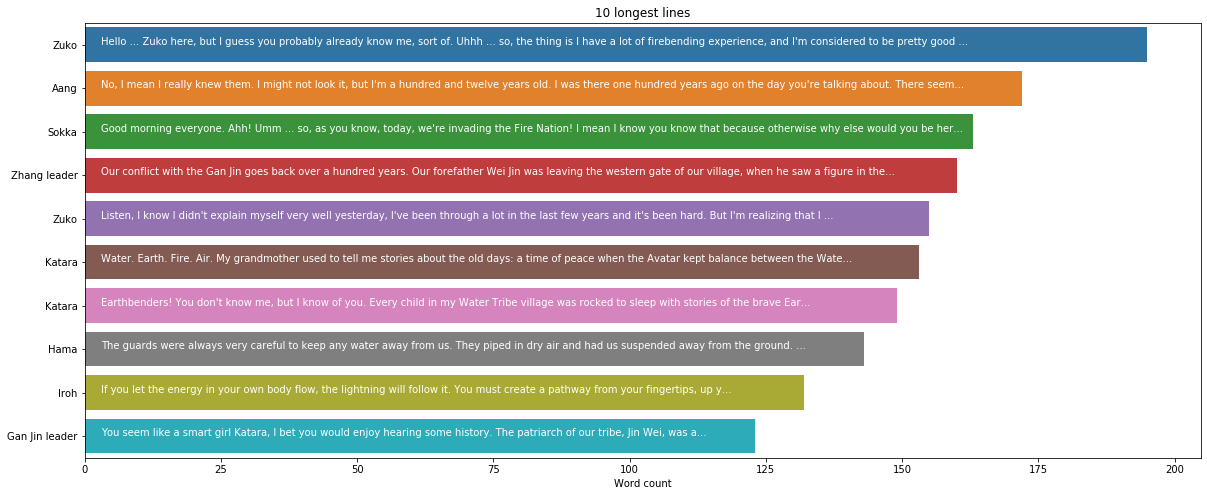

In [252]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=longest_lines["Word_count"], y=longest_lines.index, orient='h')
ax.set_xlabel("Word count")
ax.set_title("10 longest lines")
ax.set_yticklabels(longest_lines["Character"].to_list())
for index, item in enumerate(longest_lines["Utterance"].to_list()):
    ax.text(3, index, item[:175 + (-index)*6] + "...", color='white')
plt.show()